# CliMA Vegetation model
---
Modules:

Compute leaf optical properties for standard values

Compute canopy radiation (both reflectance as well as within canopy distributions for SW energy balance)

Compute photosynthesis


In [1]:
# Add PATH (adapt!)
push!(LOAD_PATH, "/Users/braghier/Documents/CliMA/CliMA-land/Land/src/Leaf/");
push!(LOAD_PATH, "/Users/braghier/Documents/CliMA/CliMA-land/Land/src/Utils/");

# Canopy optical module
---
Fixed leaf optical properties within canopt (can be changed to vertical explicity approach later as in mSCOPE)


In [2]:
#Loading required modules
using PhysCon
using WaterVaporMod
using MathTools
using Leaf
using CanopyRTMod
using BenchmarkTools
using Statistics
using Plots

┌ Info: Precompiling CanopyRTMod [top-level]
└ @ Base loading.jl:1273
┌ Warning: Module Leaf with build ID 24517809099661 is missing from the cache.
│ This may mean Leaf [top-level] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1011
┌ Info: Skipping precompilation since __precompile__(false). Importing CanopyRTMod [top-level].
└ @ Base loading.jl:1028


Reading Optical Parameters from 400.0 to 2380.0 length: 115


┌ Warning: Use of `Poly` from v1.0 forward will require `using Polynomials.PolyCompat`
│   caller = Polynomials.PolyCompat.Poly(::Array{Float32,1}) at Poly.jl:26
└ @ Polynomials.PolyCompat /Users/braghier/.julia/packages/Polynomials/ghqdF/src/polynomials/Poly.jl:26


# Run Fluspect

Leaf optical property generator (provides reflectance and transmittance)

---

INPUT: 

1) optis = optipar{typ}(loadOpti(swl)...);

A list of input variables related to leaf biological status is defined in PhotoStructs.jl, including:     

    "Leaf structure parameter"
    N::FT    = 1.5       # | -          | (1.0, 3.0)  | "Leaf structure parameter"
    "Chlorophyll a+b content"
    Cab::FT  = 40.0      # | μg cm^-2   | (0.0, 110)  | "Chlorophyll a+b content"
    "Carotenoid content"
    Car::FT  = 10.0      # | μg cm^-2   | (0.0, 40.0) | "Carotenoid content"
    "Anthocynanin content"
    Ant::FT  = 8.0       # | μg cm^-2   | (0.0, 40.0) | "Anthocynanin content"
    "Senescent material fraction"
    Cs::FT   = 0.0       # | -          | (0.0, 1.0)  | "Senescent material fraction"
    "Equivalent water thickness"
    Cw::FT   = 0.015     # | cm         | (0.0, 0.05) | "Equivalent water thickness"
    "Dry matter content (dry leaf mass per unit area)"
    Cm::FT   = 0.01      # | g cm^-2    | (0.0, 0.2)  | "Dry matter content (dry leaf mass per unit area)"
    "Fractionation between Zeaxanthin and Violaxanthin in Car (1=all Zeaxanthin)"
    Cx::FT   = 0.0       # | -          | (0.0, 1.0)  | "Fractionation between Zeaxanthin and Violaxanthin in Car (1=all Zeaxanthin)"
    "Broadband thermal reflectance"
    ρ_LW::FT = 0.01      # | -          | (0.0, 1.0)  | "Broadband thermal reflectance"
    "Broadband thermal transmission"
    τ_LW::FT = 0.01      # | -          | (0.0, 1.0)  | "Broadband thermal transmission"
    "Leaf fluorescence efficiency"
    fqe::FT = 0.01       # | -          | (0.0, 1.0)  | "Leaf fluorescence efficiency"
    
OUTPUT:

2) leaf   = leafbio{typ}(ρ_SW=similar(wl),τ_SW=similar(wl), kChlrel=similar(wl), Mb=zeros(typ,length(wle), length(wlf)), Mf=zeros(typ,length(wle), length(wlf)) );

    " leaf reflectance"
    ρ_SW::Array{FT,1}    # | -          | (0.0, 1.0)  | " leaf reflectance"
    
    " leaf transmittance"
    τ_SW::Array{FT,1}    # | -          | (0.0, 1.0)  | " leaf transmittance"
    
    "relative absorption by Chlorophyll"
    kChlrel::Array{FT,1} # | -          | (0.0, 1.0)  | "relative absorption by Chlorophyll"
    
    "Fluorescence excitation matrix backwards"
    Mb::Array{FT,2}      # | -          | (0.0, 1.0)  | "Fluorescence excitation matrix backwards"
    
    "Fluorescence excitation matrix forwards"
    Mf::Array{FT,2}      # | -          | (0.0, 1.0)  | "Fluorescence excitation matrix forwards"


In [3]:
wl = CanopyRTMod.wl;
wle = CanopyRTMod.wle;
wlf = CanopyRTMod.wlf;

arrayOfLeaves = Array{leafbio{FT,length(wl), length(wle), length(wlf),length(wle)*length(wlf)}, 1}(undef, CanopyRTMod.canopy.nlayers)
for i = 1:CanopyRTMod.canopy.nlayers
    #@show i
    arrayOfLeaves[i] = leafbio{FT, length(wl), length(wle), length(wlf),length(wle)*length(wlf)}()
    @time CanopyRTMod.fluspect!(arrayOfLeaves[i], CanopyRTMod.optis)
end

#How long does Fluspect take to run per layer? 
@time CanopyRTMod.fluspect!(leaf, CanopyRTMod.optis)
@time CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt)
@time CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);

121.200678 seconds (135.84 M allocations: 5.026 GiB, 1.85% gc time)
  0.000798 seconds (3.10 k allocations: 996.719 KiB)
  0.000691 seconds (3.10 k allocations: 996.719 KiB)
  0.000675 seconds (3.10 k allocations: 996.719 KiB)
  0.000672 seconds (3.10 k allocations: 996.719 KiB)
  0.000671 seconds (3.10 k allocations: 996.719 KiB)
  0.001023 seconds (3.10 k allocations: 996.719 KiB)
  0.001180 seconds (3.10 k allocations: 996.719 KiB)
  0.000696 seconds (3.10 k allocations: 996.719 KiB)
  0.000676 seconds (3.10 k allocations: 996.719 KiB)
  0.000721 seconds (3.10 k allocations: 996.719 KiB)
  0.000664 seconds (3.10 k allocations: 996.719 KiB)
  0.000678 seconds (3.10 k allocations: 996.719 KiB)
  0.000696 seconds (3.10 k allocations: 996.719 KiB)
  0.000744 seconds (3.10 k allocations: 996.719 KiB)
  0.000758 seconds (3.10 k allocations: 996.719 KiB)
  0.000851 seconds (3.10 k allocations: 996.719 KiB)
  0.000687 seconds (3.10 k allocations: 996.719 KiB)
  0.000678 seconds (3.10 k allo

# What are the spectral values of reflectance and transmittance?

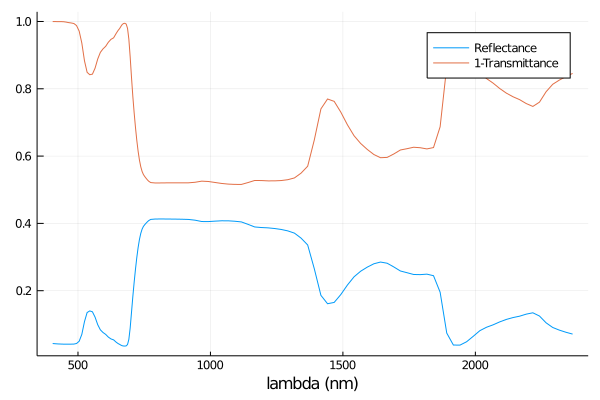

In [4]:
plot(CanopyRTMod.optis.lambda, leaf.ρ_SW, label="Reflectance")
plot!(CanopyRTMod.optis.lambda, 1 .-leaf.τ_SW, label="1-Transmittance")
xlabel!("lambda (nm)")

## Canopy Radiative Transfer module  

An adapted version of PRO-SAIL with PROSPECT-D but also adding within canopy radiation via SCOPE

---

INPUT:

FluspectMod.leaf -> Leaf optical properties (see Fluspect variables)

FluspectMod.canopy -> Canopy structural properties

    "number of canopy layers"
    nlayers::Int64     = 20    # | -          | (2, 60)      | "number of canopy layers"
    "Leaf Area Index"
    LAI::FT            = 3.0   # | -          | (0.0, 9.0)   | "Leaf Area Index"
    "Clumping factor"
    Ω::FT             = 1.0   # | -          | (0.0, 1.0)   | "clumping factor"
    "Leaf width"
    leafwidth::FT      = 0.1   # | m          | (0.0, 1.0)   | "Leaf width"
    "Vegetation height"
    hc::FT             = 2.0   # | m          | (0.0, 70.0)  | "Vegetation height"
    "Leaf Inclination"
    LIDFa::FT          = -0.35 # | -          | (-1.0, 1.0)  | "Leaf Inclination"
    "Variation in leaf inclination"
    LIDFb::FT          = -0.15 # | -          | (-1.0, 1.0)  | "Variation in leaf inclination"
    "HotSpot parameter (still need to check!)"
    hot::FT            = 0.05  # | -          | (0, 1.0)     | "HotSpot parameter (still need to check!)"
    "Leaf distribution type (2=campbell, 1=ladgen)"
    TypeLidf::FT       = 1     # | -          | (-1.0, 1.0)  | "Leaf distribution type (2=campbell, 1=ladgen)"
    "leaf azimuth angles relative to the sun"
    lazitab::Array{FT} = collect(5.0:10.0:355.0)
    
FluspectMod.angle -> Sun/Observation angular properties

    "Solar Zenith Angle in degrees"
    tts::FT=45
    "Viewing Zenith Angle in degrees"
    tto::FT=0
    "relative azimuth in degrees"
    psi::FT=0
    
FluspectMod.sunRad -> Incoming Shortwave Radiation (read from test case now, but coming from the atmosphere later on)

    "Spectral direct radiation at top of canopy"
    Edir =  suni["Edirect"]
    "Spectral direct radiation at top of canopy"
    Ediff =  suni["Ediffuse"]


### How does the Incoming Shortwave Radiation spectral curve look like?

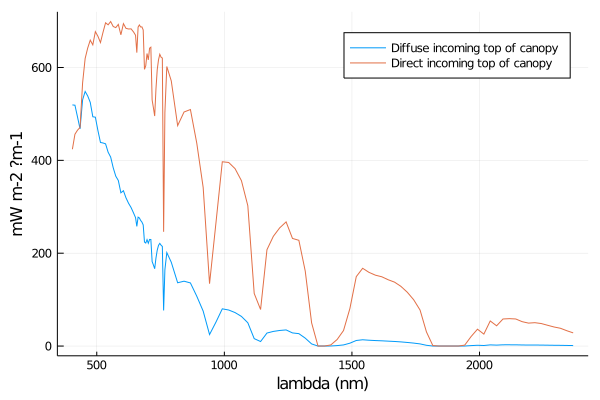

In [5]:
plot(CanopyRTMod.wl,CanopyRTMod.sunRad.E_diffuse, label="Diffuse incoming top of canopy")
plot!(CanopyRTMod.wl,CanopyRTMod.sunRad.E_direct, label="Direct incoming top of canopy")
ylabel!("mW m-2 μm-1")
xlabel!("lambda (nm)")

OUTPUT:

    "integrated TOC outgoing flux"
    intEout::FT                       # | W m^-2               | (0.0, 2500)  | "integrated TOC outgoing flux"
    "incident spectrally integrated total PAR"
    PAR::FT                           # | moles m^-2 s^-1      | (0.0, 2.5e-9)| "incident spectrally integrated total PAR"
    "incident spectrally integrated direct PAR"
    PAR_direct::FT                    # | moles m^-2 s^-1      | (0.0, 2.5e-9)| "incident spectrally integrated direct PAR"
    "incident spectrally integrated diffuse PAR"
    PAR_diffuse::FT                   # | moles m^-2 s^-1      | (0.0, 2.5e-9)| "incident spectrally integrated diffuse PAR"
    "net radiation of shaded soil"
    Rnhs::FT                          # | W m^-2               | (0.0, 2500)  | "net radiation of shaded soil"
    "net radiation of sunlit soil"
    Rnus::FT                          # | W m^-2               | (0.0, 2500)  | "net radiation of sunlit soil"
    "extinction cofficient in the solar direction"
    k::FT
    "extinction cofficient in the viewing direction"
    K::FT

    # Dim of nLayers+1
    "gap fraction in the solar direction"
    Ps::Array{FT,1}
    "gap fraction in the viewing direction"
    Po::Array{FT,1}
    "bi-derectional gap fraction (solar->canopy->viewing)"
    Pso::Array{FT,1}

    # Dim of nLayers
    "net radiation of shaded leaves"
    Rnhc::Array{FT,1}                 # | W m^-2               | (0.0, 2500)  | "net radiation of shaded leaves"
    "net PAR of shaded leaves"
    Pnh::Array{FT,1}                  # | moles m^-2 s^-1      | (0.0, 2.5e-9)| "net PAR of shaded leaves"
    "net PAR absorbed by Cab of shaded leaves"
    Pnh_Cab::Array{FT,1}              # | moles m^-2 s^-1      | (0.0, 2.5e-9)| "net PAR absorbed by Cab of shaded leaves"
    "net PAR absorbed by shaded leaves"
    Rnh_PAR::Array{FT,1}              # | W m^-2               | (0.0, 2500)  | "net PAR absorbed by shaded leaves

    # Dimension of wavelength only:
    "TOC outgoing radiance in observation direction"
    Lo::Array{FT,1}                   # | mW m^-2 μm^-1 sr^-1  | (0.0, 2500)  | "TOC outgoing radiance in observation direction"
    "TOC outgoing radiation"
    Eout::Array{FT,1}                 # | mW m^-2 μm^-1        | (0.0, 2500)  | "TOC outgoing radiation"
    "incident direct radiation at top of canopy"
    inc_SW_direct::Array{FT,1}        # | mW m^-2 μm^-1        | (0.0, 2500)  | "incident direct radiation at top of canopy"
    "incident diffuse radiation at top of canopy"
    inc_SW_diffuse::Array{FT,1}       # | mW m^-2 μm^-1        | (0.0, 2500)  | "incident diffuse radiation at top of canopy"
    "Albedo for direct incoming radiation"
    alb_direct::Array{FT,1}           # | -                    | (0.0, 1.0)   | "Albedo for direct incoming radiation"
    "Albedo for diffuse incoming radiation"
    alb_diffuse::Array{FT,1}          # | -                    | (0.0, 1.0)   | "Albedo for diffuse incoming radiation"


    # Dimension of nLayer+1 * nWavelengths
    "upwelling diffuse radiation within canopy"
    E_up::Array{FT,2}                 # | mW m^-2 μm^-1        | (0.0, 2500)  | "upwelling diffuse radiation within canopy"
    "downwelling diffuse radiation within canopy"
    E_down::Array{FT,2}               # | mW m^-2 μm^-1        | (0.0, 2500)  | "downwelling diffuse radiation within canopy"

    # Dimension of nLeafInclination * nLeafAzimuth * nLayer
    "net radiation of sunlit leaves"
    Rnuc::Array{FT,3}                 # | W m^-2               | (0.0, 2500)  | "net radiation of sunlit leaves"
    "net PAR of sunlit leaves"
    Pnu::Array{FT,3}                  # | moles m^-2 s^-1      | (0.0, 2.5e-9)| "net PAR of sunlit leaves"
    "net PAR absorbed by Cab of sunlit leaves"
    Pnu_Cab::Array{FT,3}              # | moles m^-2 s^-1      | (0.0, 2.5e-9)| "net PAR absorbed by Cab of sunlit leaves"
    "net PAR absorbed by sunlit leaves"
    Rnu_PAR::Array{FT,3}              # | W m^-2               | (0.0, 2500)  | "net PAR absorbed by sunlit leaves"


In [6]:
#How long does RTM_sail take to run? 
#can::struct_canopy, cO::struct_canopyOptProps, cR::struct_canopyRadiation, sun::incomingRadiation, so::struct_soil
@time CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil)

 88.409684 seconds (89.67 M allocations: 3.116 GiB, 1.94% gc time)


114-element StaticArrays.MArray{Tuple{114},Float32,1,114} with indices SOneTo(114):
 0.016290432
 0.016062275
 0.015888762
 0.0157636  
 0.015696695
 0.015850283
 0.01620087 
 0.016446138
 0.016843699
 0.018671557
 0.024601875
 0.040201396
 0.06853407 
 ⋮          
 0.090974286
 0.09856602 
 0.104546435
 0.1093107  
 0.116173975
 0.121077396
 0.11196489 
 0.09247425 
 0.07964221 
 0.07266019 
 0.06700982 
 0.062269643

### How does canopy albedo look like?

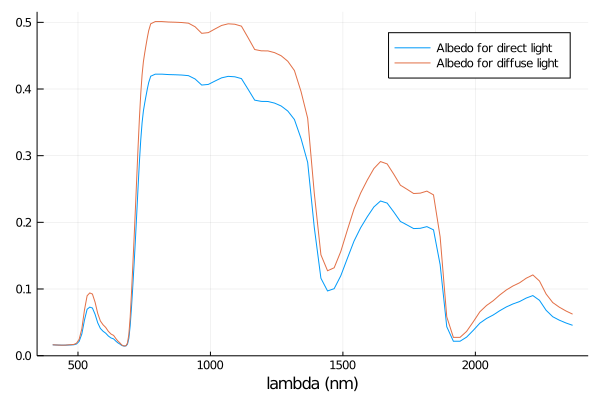

In [7]:
plot(CanopyRTMod.wl,CanopyRTMod.canRad.alb_direct, label="Albedo for direct light")
plot!(CanopyRTMod.wl,CanopyRTMod.canRad.alb_diffuse, label="Albedo for diffuse light")
xlabel!("lambda (nm)")

### What is the value of transmitted radiation reaching the soil?

Soil is still defined as polynomial (depends on state vector size), still TBD in the structure mode. Currently:

    pSoil =  Polynomials.Poly(typ(0.2))
    rsoil = Polynomials.polyval(pSoil,wl.-mean(wl));
    soil_emissivity = 1 .-rsoil # emissivity of soil (goes into structure later)

In [8]:
@time CanopyRTMod.deriveCanopyFluxes!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil, arrayOfLeaves);

println("Net radiation diffuse soil  ", CanopyRTMod.canRad.RnSoil_diffuse)
println("Net radiation direct soil  ", CanopyRTMod.canRad.RnSoil_direct)
println("Net radiation soil  ", CanopyRTMod.canRad.RnSoil_direct+CanopyRTMod.canRad.RnSoil_diffuse)

  4.866218 seconds (15.98 M allocations: 611.874 MiB, 4.03% gc time)
Net radiation diffuse soil  60.563007
Net radiation direct soil  51.121838
Net radiation soil  111.684845


### Leaf photosynthesis module

In [9]:
# Create a leaf structure
l = leaf_params{Float32}();
l2 = leaf_params{Float32}();
# Create a Flux structure
f = Leaf.fluxes{Float32}();

In [10]:
# initialize some reasonable values
f.je = 100;
f.gbc = 100;
f.gbv = 100;
f.ceair =1500;
f.eair = 1500;
#f.APAR = 500;
#vertical mean of net PAR absorbed by Cab of sunlit leaves"
APAR_sunlit = mean(CanopyRTMod.canOpt.Ps[1:end-1].*mean(CanopyRTMod.canRad.absPAR_sun*1e6, dims=1:2)[1,1,:]);  
#vertical mean of net PAR absorbed by Cab of shaded leaves"
APAR_shaded = mean((1 .- CanopyRTMod.canOpt.Ps[1:end-1]).*mean(CanopyRTMod.canRad.absPAR_shade*1e6, dims=1:2)[1,1,:]);  
f.APAR = APAR_sunlit + APAR_shaded
println("Sunlit absorbed PAR  ",APAR_sunlit)
println("Shaded absorbed PAR  ",APAR_shaded)
println("Total absorbed PAR  ",f.APAR)

Sunlit absorbed PAR  359.5962855324405
Shaded absorbed PAR  106.95767665853782
Total absorbed PAR  466.55396


In [43]:
l.Kn = 2.44

#Temperature em Celsius
Temp = 24.85

#How long does the leaf photosynthesis module take to run? 
@time Leaf.LeafPhotosynthesis(f,l,(Temp + 273.15),f.APAR);

  0.000053 seconds (244 allocations: 4.953 KiB)


### Get some PAR response curves

In [44]:
apar = Float32[]
gpp_sunlit_1  = Float32[]
gpp_shaded_1  = Float32[]
apar_ = Float32[]
gpp_sunlit_2  = Float32[]
gpp_shaded_2  = Float32[]
gpp_total_1  = Float32[]
gpp_total_2  = Float32[]
f.cair = 400
l.vcmax25 = 90
l.jmax25 = 90*1.9
l2.vcmax25 = 50
l2.jmax25 = 50*1.9


vertical_APAR_sunlit = CanopyRTMod.canOpt.Ps[1:end-1].*mean(CanopyRTMod.canRad.absPAR_sun*1e6, dims=1:2)[1,1,:]

vertical_APAR_shaded =(1 .- CanopyRTMod.canOpt.Ps[1:end-1]).*mean(CanopyRTMod.canRad.absPAR_shade*1e6, dims=1:2)[1,1,:] 

vertical_APAR = vertical_APAR_sunlit .+ vertical_APAR_shaded

#Sunlit
#for f.APAR in 0:10:1000
for f.APAR in vertical_APAR_sunlit
    Leaf.LeafPhotosynthesis(f,l,(Temp + 273.15),f.APAR);
    push!(apar, f.APAR)
    push!(gpp_sunlit_1, f.an)
    Leaf.LeafPhotosynthesis(f,l2,(Temp + 273.15),f.APAR);
    push!(apar_, f.APAR)
    push!(gpp_sunlit_2, f.an)
    #println(f.APAR, " ", f.ag, " ", f.an)
end

#Shaded
for f.APAR in vertical_APAR_shaded
    Leaf.LeafPhotosynthesis(f,l,(Temp + 273.15),f.APAR);
    push!(apar, f.APAR)
    push!(gpp_shaded_1, f.an)
    Leaf.LeafPhotosynthesis(f,l2,(Temp + 273.15),f.APAR);
    push!(apar_, f.APAR)
    push!(gpp_shaded_2, f.an)
    #println(f.APAR, " ", f.ag, " ", f.an)
end

gpp_total_1 = ( CanopyRTMod.canOpt.Ps[1:end-1]).*(gpp_sunlit_1) + (1 .-CanopyRTMod.canOpt.Ps[1:end-1].*(gpp_shaded_1))
gpp_total_2 = ( CanopyRTMod.canOpt.Ps[1:end-1]).*(gpp_sunlit_2) + (1 .-CanopyRTMod.canOpt.Ps[1:end-1].*(gpp_shaded_2))

20-element Array{Float32,1}:
 10.762833  
  9.016588  
  7.592651  
  6.416065  
  5.4425015 
  4.636947  
  3.971825  
  3.4237106 
  2.9730794 
  2.6037471 
  2.3019447 
  2.051621  
  1.7811291 
  1.5271914 
  1.2838016 
  1.0581295 
  0.8628825 
  0.7062026 
  0.58699524
  0.5012288 

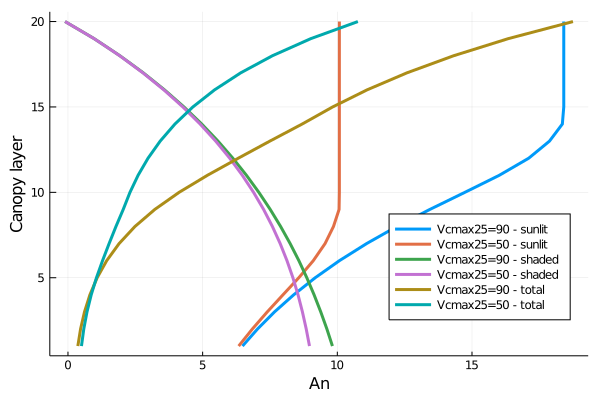

In [45]:
# Test the impact of Vcmax on vertical photosynthesis
plot(reverse(gpp_sunlit_1),[1:1:CanopyRTMod.canopy.nlayers],lw=3, label="Vcmax25=90 - sunlit", ylabel="Canopy layer", xlabel="An")
plot!(reverse(gpp_sunlit_2),[1:1:CanopyRTMod.canopy.nlayers],lw=3, label="Vcmax25=50 - sunlit")
plot!(reverse(gpp_shaded_1),[1:1:CanopyRTMod.canopy.nlayers],lw=3, label="Vcmax25=90 - shaded")
plot!(reverse(gpp_shaded_2),[1:1:CanopyRTMod.canopy.nlayers],lw=3, label="Vcmax25=50 - shaded")
plot!(reverse(gpp_total_1),[1:1:CanopyRTMod.canopy.nlayers],lw=3, label="Vcmax25=90 - total")
plot!(reverse(gpp_total_2),[1:1:CanopyRTMod.canopy.nlayers],lw=3, label="Vcmax25=50 - total",legend=:bottomright)


### Get some PAR response curves

In [39]:
print("Vcmax25=90","Total GPP =",sum(gpp_total_1)./CanopyRTMod.canopy.nlayers,"\n")
print("Vcmax25=50","Total GPP =",sum(gpp_total_2)./CanopyRTMod.canopy.nlayers)

Vcmax25=90Total GPP =6.3571873
Vcmax25=50Total GPP =3.4750538

In [40]:
# Test T dependence
T_ = Float32[]
ag_T_  = Float32[]
an_T_  = Float32[]
vcmax_T_  = Float32[]
electron_co2_T_  = Float32[]
gamma_T_  = Float32[]
#f.APAR = 500
f.APAR = APAR_sunlit + APAR_shaded

for T in 260:1:320
    Leaf.LeafPhotosynthesis(f,l,T,f.APAR);
    push!(T_, T)
    push!(ag_T_, f.ag)
    push!(an_T_, f.an)
    push!(vcmax_T_, l.vcmax)
    push!(electron_co2_T_, l.CO2_per_electron)
    push!(gamma_T_ , l.Γstar)
end

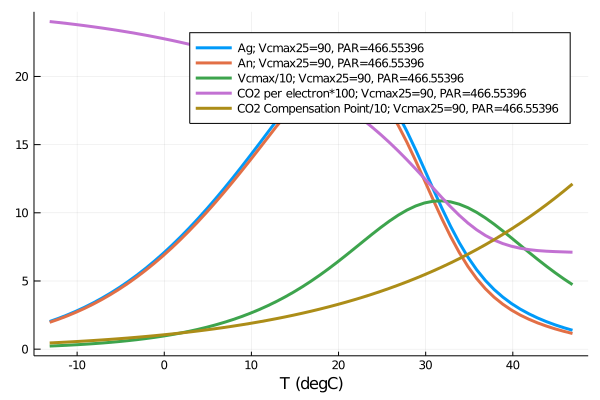

In [41]:
m = f.APAR
plot(T_.-273.15, ag_T_, lw=3, label="Ag; Vcmax25=90, PAR=$m",  xlabel="T (degC)")
plot!(T_.-273.15, an_T_, lw=3, label="An; Vcmax25=90, PAR=$m")
plot!(T_.-273.15, vcmax_T_/10, lw=3, label="Vcmax/10; Vcmax25=90, PAR=$m")
plot!(T_.-273.15, electron_co2_T_*100, lw=3, label="CO2 per electron*100; Vcmax25=90, PAR=$m")
plot!(T_.-273.15, gamma_T_/10, lw=3, label="CO2 Compensation Point/10; Vcmax25=90, PAR=$m")